#1 Packages

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import os
import tensorflow as tf
import tensorflow.keras.layers as tfl

from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.layers.experimental.preprocessing import RandomFlip, RandomRotation, RandomCrop, RandomZoom, RandomContrast


# 1.1 Create the Dataset and Split it into Training and Validation Sets


In [2]:
BATCH_SIZE = 32
IMG_SIZE = (224, 224)
directory = "D:\\University\\ArchitectureStyles\\archive\\architectural-styles-dataset"
train_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             label_mode='categorical',
                                             subset='training',
                                             seed=42)
validation_dataset = image_dataset_from_directory(directory,
                                             shuffle=True,
                                             batch_size=BATCH_SIZE,
                                             image_size=IMG_SIZE,
                                             validation_split=0.2,
                                             subset='validation',
                                             label_mode='categorical',
                                             seed=42)

Found 10112 files belonging to 25 classes.
Using 8090 files for training.
Found 10112 files belonging to 25 classes.
Using 2022 files for validation.


Represent data

['Achaemenid architecture', 'American Foursquare architecture', 'American craftsman style', 'Ancient Egyptian architecture', 'Art Deco architecture', 'Art Nouveau architecture', 'Baroque architecture', 'Bauhaus architecture', 'Beaux-Arts architecture', 'Byzantine architecture', 'Chicago school architecture', 'Colonial architecture', 'Deconstructivism', 'Edwardian architecture', 'Georgian architecture', 'Gothic architecture', 'Greek Revival architecture', 'International style', 'Novelty architecture', 'Palladian architecture', 'Postmodern architecture', 'Queen Anne architecture', 'Romanesque architecture', 'Russian Revival architecture', 'Tudor Revival architecture']


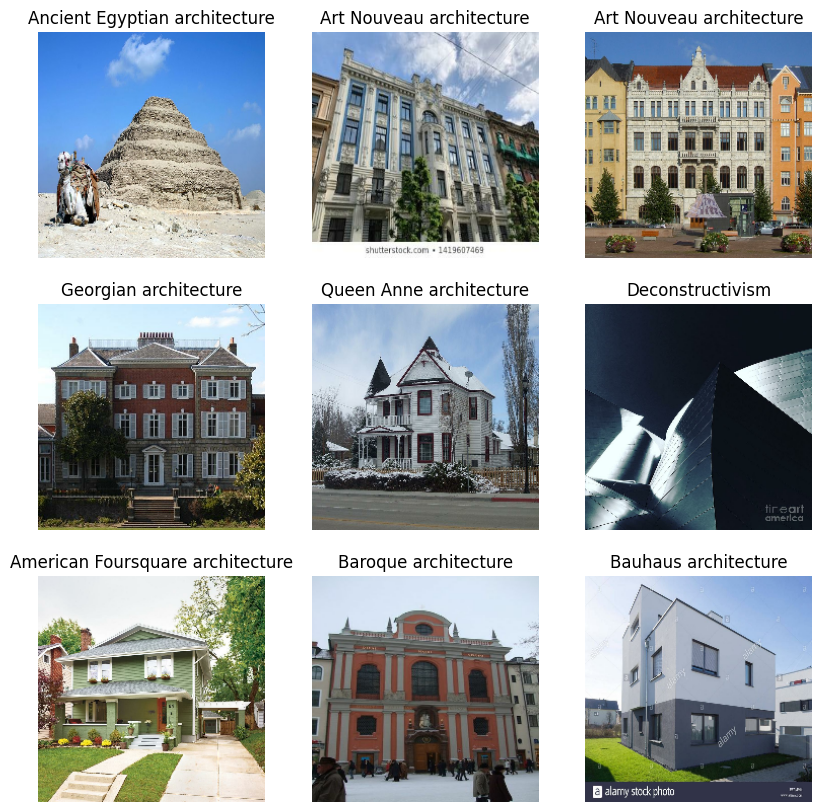

In [3]:
class_names = sorted(os.listdir(directory))
print(class_names)

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[np.argmax(labels[i])])  # Convert one-hot encoded labels to class names
        plt.axis("off")
plt.show()

# 2 Preprocess and Augment Training Data

In [4]:
AUTOTUNE = tf.data.experimental.AUTOTUNE
train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)

In [5]:
def data_augmenter():
    data_augmentation = tf.keras.Sequential([])
    data_augmentation.add(RandomFlip('horizontal'))
    data_augmentation.add(RandomRotation(0.1))
    data_augmentation.add(RandomZoom(0.2))
    data_augmentation.add(RandomCrop(height=IMG_SIZE[0], width=IMG_SIZE[1]))
    data_augmentation.add(RandomContrast(factor=0.2))
    return data_augmentation

Augumented images

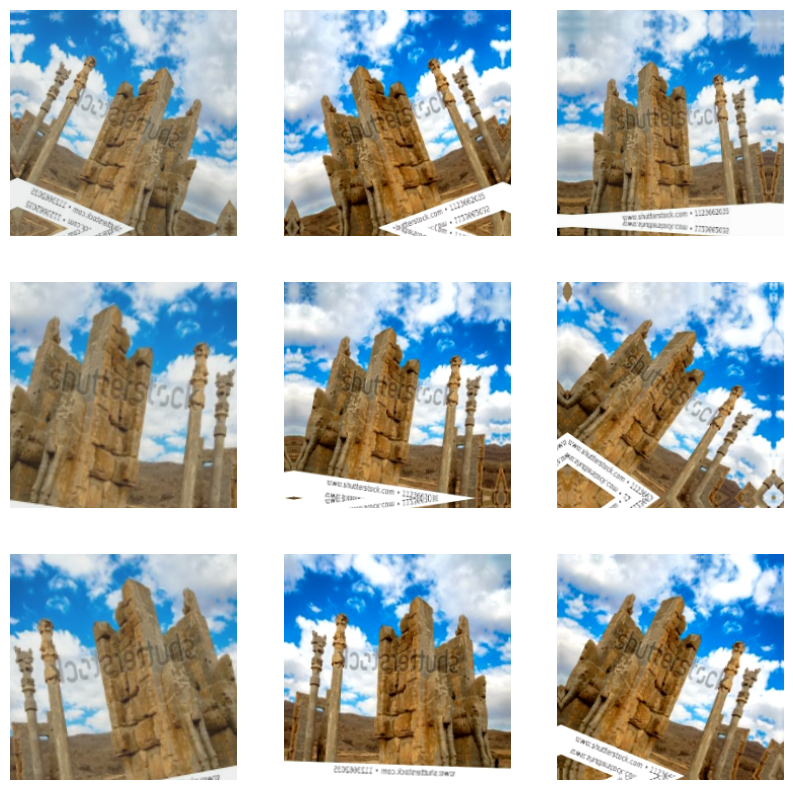

In [6]:
data_augmentation = data_augmenter()

for image, _ in train_dataset.take(1):
    plt.figure(figsize=(10, 10))
    first_image = image[0]
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        augmented_image = data_augmentation(tf.expand_dims(first_image, 0))
        plt.imshow(augmented_image[0] / 255)
        plt.axis('off')

In [7]:
IMG_SHAPE = IMG_SIZE + (3,)
base_model = tf.keras.applications.MobileNetV2(input_shape=IMG_SHAPE,
                                               include_top=True,
                                               weights='imagenet')

In [8]:
image_batch, label_batch = next(iter(train_dataset))
feature_batch = base_model(image_batch)
print(feature_batch.shape)
preprocess_input = tf.keras.applications.efficientnet_v2.preprocess_input

(32, 1000)


# 3 Using EfficientNetB0V2

In [13]:
def arc_model(image_shape=IMG_SIZE, data_augmentation=data_augmenter()):
    input_shape = image_shape + (3,)
    base_model = tf.keras.applications.EfficientNetV2B0(input_shape=input_shape,
                                                   include_top=False,
                                                   weights='imagenet')
    base_model.trainable = False
    inputs = tf.keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    x = preprocess_input(x)

    x = base_model(x, training=False)

    x = tf.keras.layers.GlobalAveragePooling2D()(x)
    x = tf.keras.layers.Dropout(0.8)(x)
    x = tf.keras.layers.Dense(1024,activation='relu')(x)
    x = tf.keras.layers.BatchNormalization(x)
    # x = tf.keras.layers.Dropout(0.8)(x)
    x = tf.keras.layers.Dense(1024,activation='relu')(x)
    x = tf.keras.layers.BatchNormalization(x)
    # x = tf.keras.layers.Dropout(0.8)(x)
    x = tf.keras.layers.Dense(512,activation='relu')(x)
    # x = tf.keras.layers.Dropout(0.5)(x)
    x = tf.keras.layers.BatchNormalization(x)
    x = tf.keras.layers.Dense(256, activation='relu')(x)
    x = tf.keras.layers.BatchNormalization(x)
    x = tf.keras.layers.Dropout(0.5)(x)

    outputs = tf.keras.layers.Dense(25, activation='softmax')(x)
    model = tf.keras.Model(inputs, outputs)

    return model

In [14]:
model2 = arc_model(IMG_SIZE, data_augmentation)
base_learning_rate = 0.001
model2.compile(optimizer=tf.keras.optimizers.Adam(lr=base_learning_rate),
              loss=tf.keras.losses.CategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
initial_epochs = 10
history = model2.fit(train_dataset, validation_data=validation_dataset, epochs=initial_epochs)

Epoch 1/10
253/253 [==============================] - 162s 609ms/step - loss: 2.6225 - accuracy: 0.2033 - val_loss: 1.9136 - val_accuracy: 0.3922
Epoch 2/10
253/253 [==============================] - 153s 602ms/step - loss: 2.1669 - accuracy: 0.3283 - val_loss: 1.6557 - val_accuracy: 0.4624
Epoch 3/10
253/253 [==============================] - 152s 601ms/step - loss: 2.0268 - accuracy: 0.3658 - val_loss: 1.5463 - val_accuracy: 0.5049
Epoch 4/10
253/253 [==============================] - 152s 598ms/step - loss: 1.9536 - accuracy: 0.3952 - val_loss: 1.5126 - val_accuracy: 0.4941
Epoch 5/10
253/253 [==============================] - 152s 600ms/step - loss: 1.8919 - accuracy: 0.4059 - val_loss: 1.5175 - val_accuracy: 0.5074
Epoch 6/10
253/253 [==============================] - 152s 598ms/step - loss: 1.8524 - accuracy: 0.4294 - val_loss: 1.4444 - val_accuracy: 0.5321
Epoch 7/10
253/253 [==============================] - 152s 600ms/step - loss: 1.8208 - accuracy: 0.4336 - val_loss: 1.4397 -

Results

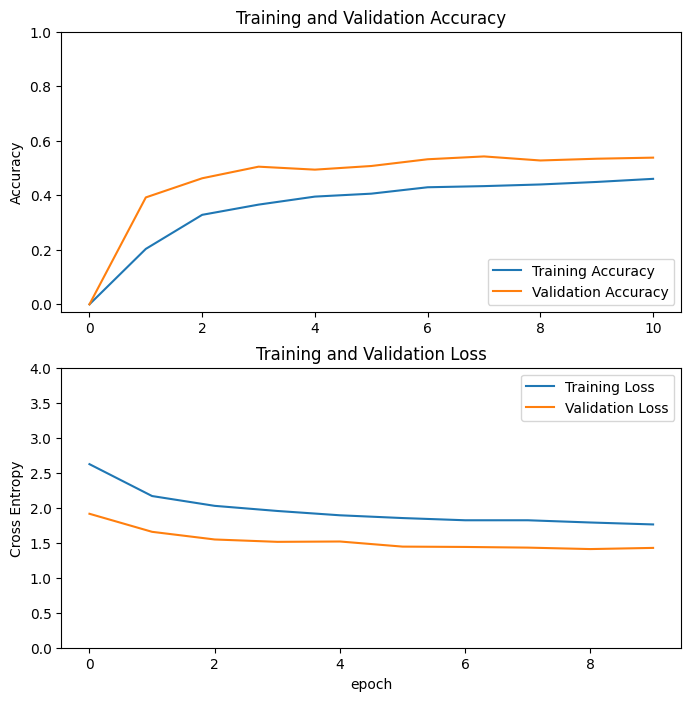

In [15]:
acc = [0.] + history.history['accuracy']
val_acc = [0.] + history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']
plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.ylabel('Accuracy')
plt.ylim([min(plt.ylim()),1])
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.ylabel('Cross Entropy')
plt.ylim([0,4.0])
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [16]:
from tensorflow.keras import layers

base_model = model2
base_model.trainable = True

fine_tune_at = -10

for layer in base_model.layers[:fine_tune_at]:
    if not isinstance(layer, layers.BatchNormalization):
        layer.trainable = False


loss_function=tf.keras.losses.CategoricalCrossentropy(from_logits=True)
# Define an Adam optimizer with a learning rate of 0.1 * base_learning_rate
optimizer = tf.keras.optimizers.Adam(learning_rate=0.1 * base_learning_rate)
# Use accuracy as evaluation metric
metrics=['accuracy']

model2.compile(loss=loss_function,
              optimizer = optimizer,
              metrics=metrics)

fine_tune_epochs = 20
total_epochs =  initial_epochs + fine_tune_epochs

history_fine = model2.fit(train_dataset,
                         epochs=total_epochs,
                         initial_epoch=history.epoch[-1],
                         validation_data=validation_dataset)

Epoch 10/30
253/253 [==============================] - 476s 2s/step - loss: 1.6005 - accuracy: 0.4985 - val_loss: 1.2831 - val_accuracy: 0.5643
Epoch 11/30
253/253 [==============================] - 443s 2s/step - loss: 1.3751 - accuracy: 0.5663 - val_loss: 1.1930 - val_accuracy: 0.6172
Epoch 12/30
253/253 [==============================] - 443s 2s/step - loss: 1.2645 - accuracy: 0.5994 - val_loss: 1.1677 - val_accuracy: 0.6316
Epoch 13/30
253/253 [==============================] - 443s 2s/step - loss: 1.1785 - accuracy: 0.6256 - val_loss: 1.1372 - val_accuracy: 0.6459
Epoch 14/30
253/253 [==============================] - 443s 2s/step - loss: 1.1170 - accuracy: 0.6491 - val_loss: 1.1179 - val_accuracy: 0.6588
Epoch 15/30
253/253 [==============================] - 443s 2s/step - loss: 1.0374 - accuracy: 0.6706 - val_loss: 1.1032 - val_accuracy: 0.6627
Epoch 16/30
253/253 [==============================] - 452s 2s/step - loss: 0.9496 - accuracy: 0.6959 - val_loss: 1.0853 - val_accuracy:

Results

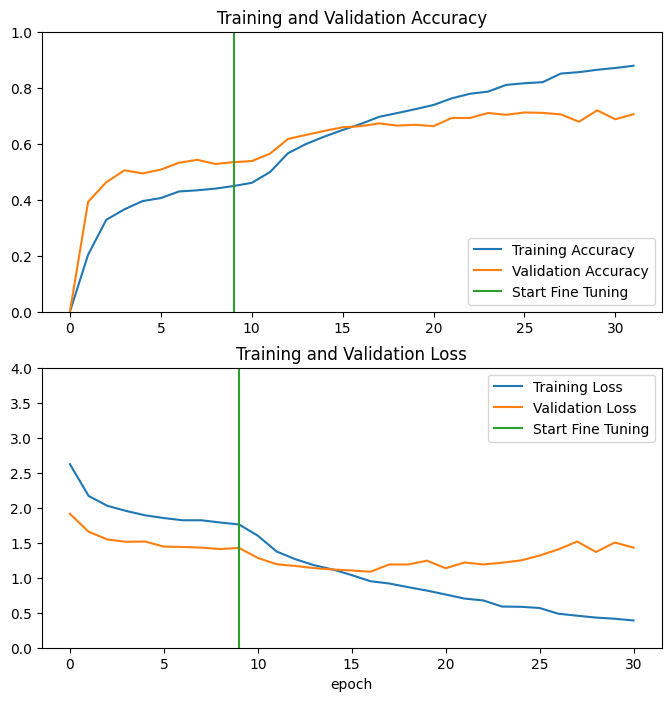

In [17]:
acc += history_fine.history['accuracy']
val_acc += history_fine.history['val_accuracy']

loss += history_fine.history['loss']
val_loss += history_fine.history['val_loss']

plt.figure(figsize=(8, 8))
plt.subplot(2, 1, 1)
plt.plot(acc, label='Training Accuracy')
plt.plot(val_acc, label='Validation Accuracy')
plt.ylim([0, 1])
plt.plot([initial_epochs-1,initial_epochs-1],
          plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(2, 1, 2)
plt.plot(loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.ylim([0, 4.0])
plt.plot([initial_epochs-1,initial_epochs-1],
         plt.ylim(), label='Start Fine Tuning')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.xlabel('epoch')
plt.show()

In [24]:
model_name = "tf_architecture_keras_efficient.v3"
model2.save(f"models/{model_name}.h5")

C:\Users\User\AppData\Local\Programs\Python\Python310\lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [25]:
converter = tf.lite.TFLiteConverter.from_keras_model(model2)
tflite_model = converter.convert()

# Save the TFLite model to a file
with open('models/arcitecv4.tflite', 'wb') as f:
    f.write(tflite_model)

INFO:tensorflow:Assets written to: C:\Temp\tmpga9ehquy\assets


INFO:tensorflow:Assets written to: C:\Temp\tmpga9ehquy\assets
